In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
from dataset import *
from save_load import *
from NN_library.VPINN.VPINN import *
from NN_library.VPINN.train_VPINN import *

Using device: cuda


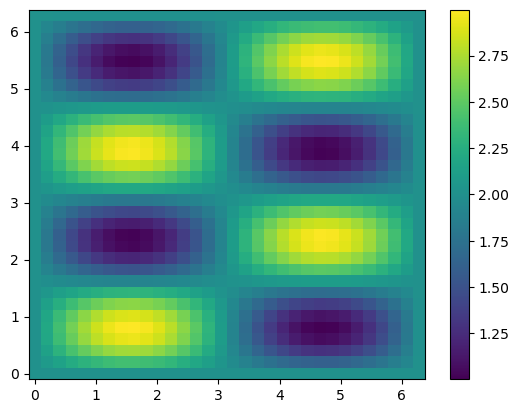

In [2]:
L = 2*np.pi
N = 32 # number of nodes in each direction including the border
H1 = torch.tensor([1, 0], device=dev).view(1, 2) # macrogradient
H2 = torch.tensor([0, 1], device=dev).view(1, 2) # macrogradient
x = np.linspace(0, L, N, endpoint=True)
y = np.linspace(0, L, N, endpoint=True)

XY = np.meshgrid(x, y)
grid_data = torch.tensor(np.vstack((XY[0].flatten(), XY[1].flatten())).T, dtype=torch.float, device=dev)
def a_function(x,y):
    a = 2+np.sin(x)*np.sin(2*y)
    return a
def A_matrix_np(x):
    a = (2+np.sin(x[0])*np.sin(2*x[1]))
    I = np.eye(2)
    A = a * I
    return A
def A_matrix(x):
    a = (2+torch.sin(x[:,0])*torch.sin(2*x[:,1])).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a * I
    return A
Z = a_function(XY[0].flatten(),XY[1].flatten())
plt.pcolormesh(XY[0], XY[1], Z.reshape(N, N))
plt.colorbar()

In [ ]:
def eig_func(x)

In [3]:
args = {'lr' : 0.00001, 'epochs' : 2000, 'dev' : dev, 'name' : 'NN_library/VPINN/VPINN_H1'}
net_H1 = VPINN(n_periodic=10, n_hidden=30, n_layers=5, period_len=L)
total_params = sum(p.numel() for p in net_H1.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 5411


In [40]:
x1 = XY[0].flatten()
x2 = XY[1].flatten()
triang = Triangulation(x1,x2)
xi = np.eye(2)

f1 = np.argwhere(x2 == 0).flatten()
f2 = np.argwhere(x2 == L).flatten()
f3 = np.argwhere(x1 == 0).flatten()
f4 = np.argwhere(x1 == L).flatten()

# Construct Gram matrix G 
n_elem = len(triang.triangles)
n_nodes = len(x1)
G = np.zeros((n_nodes, n_nodes))

# Find unique nodes belonging to the master and copy faces in the periodic BCs
master_nodes = np.union1d(f1, f3)
master_nodes = np.setdiff1d(master_nodes, f2)
master_nodes = np.setdiff1d(master_nodes, f4)
copy_nodes = np.union1d(f2, f4)
copy_nodes = np.setdiff1d(copy_nodes, master_nodes)
free_nodes = np.setdiff1d(np.arange(n_nodes), copy_nodes)
n_master = len(master_nodes)
n_free = len(free_nodes)
D_grad_test = np.zeros((n_elem, 2, 3))
f = np.zeros((n_nodes, 2))
areas = np.zeros((n_elem, 1))

for i in range(n_elem):
    elem = triang.triangles[i]
    node_coords_x1 = x1[elem]
    node_coords_x2 = x2[elem]
    vector_x1 = node_coords_x1[1:]-node_coords_x1[:-1]
    vector_x2 = node_coords_x2[1:]-node_coords_x2[:-1]
    vectors = np.column_stack((vector_x1, vector_x2, [0, 0]))
    area = (1/2) * abs(np.cross(vectors[0], vectors[1])[-1])
    center = np.array([np.mean(node_coords_x1), np.mean(node_coords_x2)])
    M = np.column_stack(([1, 1, 1], node_coords_x1, node_coords_x2))
    M_inv = np.linalg.inv(M)
    D_grad = M_inv[1:]
    G_elem = area * D_grad.T @ D_grad
    G[np.ix_(elem, elem)] += G_elem
    D_grad_test[i] = D_grad
    A = A_matrix_np(center)
    f_elem = -area * D_grad.T @ A @ xi
    f[elem] += f_elem
    areas[i] = area
    
G_copy = G.copy()
G_copy[:,f1] += G_copy[:,f2]
G_copy[f1,:] += G_copy[f2,:]
G_copy[:,f3] += G_copy[:,f4]
G_copy[f3,:] += G_copy[f4,:]
G_per = G_copy[np.ix_(free_nodes, free_nodes)]

f_copy = f.copy()
f_copy[f1] += f_copy[f2]
f_copy[f3] += f_copy[f4]
f_per = f_copy[free_nodes]

G_inv = np.linalg.inv(G_per)

G_inv = torch.tensor(G_inv, dtype=torch.float)
f_per = torch.tensor(f_per, dtype=torch.float)
D_grad_test = torch.tensor(D_grad_test, dtype=torch.float)

In [34]:
# Construct residual 
K = torch.zeros((n_nodes, n_nodes))

In [57]:
grid_points = np.vstack((x1, x2)).T
grid_points = torch.tensor(grid_points, dtype=torch.float)
grid_points = grid_points.requires_grad_(True)

In [59]:
T_tilde = net_H1(grid_points)

In [ ]:
grad_y = torch.autograd.grad(
        outputs=y, inputs=x,
        grad_outputs=torch.ones_like(y),
        create_graph=True, retain_graph=True
    )[0]

In [10]:
for i in range(n_elem):
    elem = triang.triangles[i]
    node_coords_x1 = x1[elem]
    node_coords_x2 = x2[elem]
    vector_x1 = node_coords_x1[1:]-node_coords_x1[:-1]
    vector_x2 = node_coords_x2[1:]-node_coords_x2[:-1]
    vectors = np.column_stack((vector_x1, vector_x2, [0, 0]))
    area = (1/2) * abs(np.cross(vectors[0], vectors[1])[-1])
    center = [np.mean(node_coords_x1), np.mean(node_coords_x2)]
    A = A_matrix(torch.[center[0], center[1])
    D_grad
    K_elem = area * D_grad_test.T @ A @ D_grad[i]
    K[np.ix_(elem, elem)] += K_elem

In [13]:
# Find unique nodes belonging to the master and copy faces in the periodic BCs
master_nodes = np.union1d(f1, f3)
master_nodes = np.setdiff1d(master_nodes, f2)
master_nodes = np.setdiff1d(master_nodes, f4)
copy_nodes = np.union1d(f2, f4)
copy_nodes = np.setdiff1d(copy_nodes, master_nodes)
free_nodes = np.setdiff1d(np.arange(n_nodes), copy_nodes)
n_master = len(master_nodes)
n_free = len(free_nodes)

In [14]:
K_copy = K.copy()
K_copy[:,f1] += K_copy[:,f2]
K_copy[f1,:] += K_copy[f2,:]
K_copy[:,f3] += K_copy[:,f4]
K_copy[f3,:] += K_copy[f4,:]
K_per = K_copy[np.ix_(free_nodes, free_nodes)]

K_inv_copy = K_inv.copy()
K_inv_copy[:,f1] += K_inv_copy[:,f2]
K_inv_copy[f1,:] += K_inv_copy[f2,:]
K_inv_copy[:,f3] += K_inv_copy[:,f4]
K_inv_copy[f3,:] += K_inv_copy[f4,:]
K_inv_copy[:,f1+n_nodes] += K_inv_copy[:,f2+n_nodes]
K_inv_copy[f1+n_nodes,:] += K_inv_copy[f2+n_nodes,:]
K_inv_copy[:,f3+n_nodes] += K_inv_copy[:,f4+n_nodes]
K_inv_copy[f3+n_nodes,:] += K_inv_copy[f4+n_nodes,:]
free_nodes_2 = np.hstack((free_nodes, free_nodes+n_nodes))
K_inv_per = K_inv_copy[np.ix_(free_nodes_2, free_nodes_2)]

In [15]:
f_copy = f.copy()
f_copy[f1] += f_copy[f2]
f_copy[f3] += f_copy[f4]
f_per = f_copy[free_nodes]

f_inv_copy = f_inv.copy()
f_inv_copy[f1] += f_inv_copy[f2]
f_inv_copy[f3] += f_inv_copy[f4]
f_inv_copy[f1+n_nodes] += f_inv_copy[f2+n_nodes]
f_inv_copy[f3+n_nodes] += f_inv_copy[f4+n_nodes]
f_inv_per = f_inv_copy[free_nodes_2]

In [16]:
U_per_1 = cg(bsr_matrix(K_per), f_per[:,0], tol=1e-6)
U_per_2 = cg(bsr_matrix(K_per), f_per[:,1], tol=1e-6)
W_per_1 = cg(bsr_matrix(K_inv_per), f_inv_per[:,0], tol=1e-6)
W_per_2 = cg(bsr_matrix(K_inv_per), f_inv_per[:,1], tol=1e-6)

In [17]:
U = np.zeros((n_nodes,2))
U[free_nodes, 0] = U_per_1[0]
U[free_nodes, 1] = U_per_2[0]
U[f2] = U[f1]
U[f4] = U[f3]

W = np.zeros((2*n_nodes,2))
W[free_nodes_2, 0] = W_per_1[0]
W[free_nodes_2, 1] = W_per_2[0]
W[f2] = W[f1]
W[f4] = W[f3]
W[f2+n_nodes] = W[f1+n_nodes]
W[f4+n_nodes] = W[f3+n_nodes]

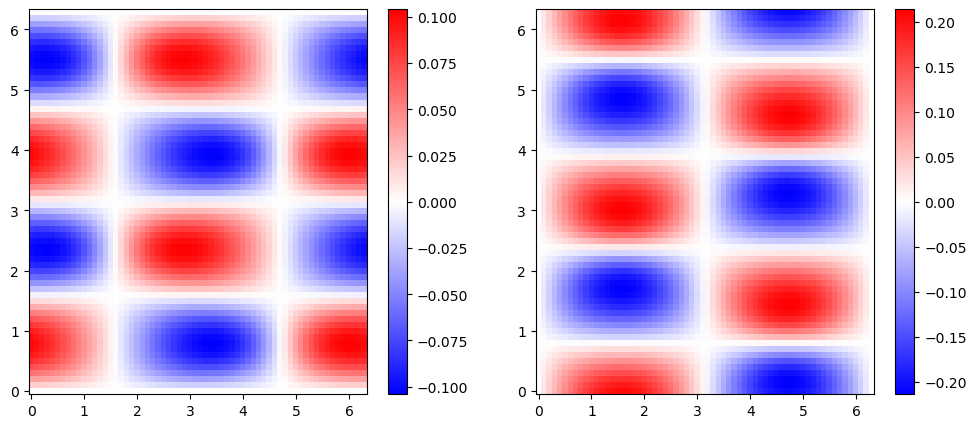

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
pos1 = axs[0].pcolormesh(XY[0], XY[1], U[:,0].reshape(N, N), cmap='bwr')
pos2 = axs[1].pcolormesh(XY[0], XY[1], U[:,1].reshape(N, N), cmap='bwr')
fig.colorbar(pos1, ax=axs[0])
fig.colorbar(pos2, ax=axs[1])

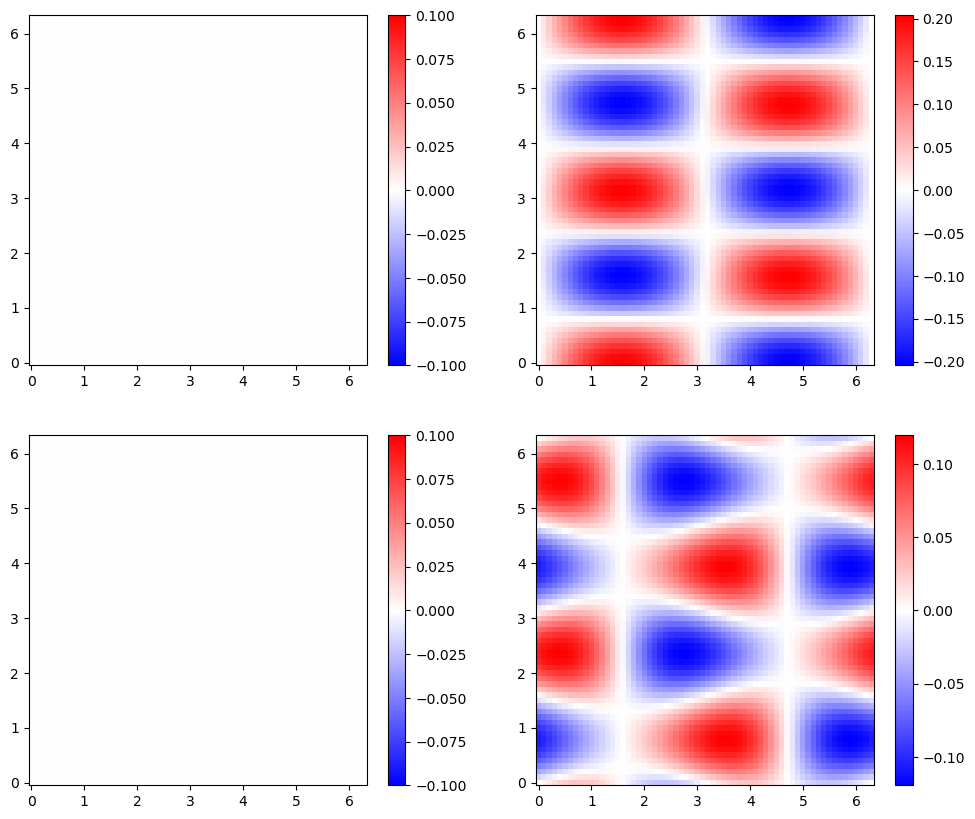

In [20]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
pos1 = axs[0,0].pcolormesh(XY[0], XY[1], W[:n_nodes,0].reshape(N, N), cmap='bwr')
pos2 = axs[0,1].pcolormesh(XY[0], XY[1], W[n_nodes:,0].reshape(N, N), cmap='bwr')
pos3 = axs[1,0].pcolormesh(XY[0], XY[1], W[:n_nodes,1].reshape(N, N), cmap='bwr')
pos4 = axs[1,1].pcolormesh(XY[0], XY[1], W[n_nodes:,1].reshape(N, N), cmap='bwr')
fig.colorbar(pos1, ax=axs[0,0])
fig.colorbar(pos2, ax=axs[0,1])
fig.colorbar(pos3, ax=axs[1,0])
fig.colorbar(pos4, ax=axs[1,1])

In [22]:
# Compute the A_h, B_h2 - upper and lower bounds to the homogenized parameters
A_h = np.zeros((2,2))
B_h = np.zeros((2,2))
for i in range(n_elem):
    elem = triang.triangles[i]
    elem_2 = np.hstack((elem, elem+n_nodes))
    node_coords_x1 = x1[elem]
    node_coords_x2 = x2[elem]
    vector_x1 = node_coords_x1[1:]-node_coords_x1[:-1]
    vector_x2 = node_coords_x2[1:]-node_coords_x2[:-1]
    vectors = np.column_stack((vector_x1, vector_x2, [0, 0]))
    area = (1/2) * abs(np.cross(vectors[0], vectors[1])[-1])
    center = [np.mean(node_coords_x1), np.mean(node_coords_x2)]
    A = A_matrix(center[0], center[1])
    A_inv = np.linalg.inv(A)
    M = np.column_stack(([1, 1, 1], node_coords_x1, node_coords_x2))
    M_inv = np.linalg.inv(M)
    D_grad = M_inv[1:]
    D_curl = np.zeros((2, 6))
    D_curl[0,3:] = -D_grad[1]
    D_curl[1,3:] = D_grad[0]
    g_elem = D_grad @ U[elem] + xi
    curl = D_curl @ W[elem_2] + xi  
    A_h_elem = area * g_elem.T @ A @ g_elem
    A_h += A_h_elem
    B_h_elem = area * curl.T @ A_inv @ curl
    B_h += B_h_elem

print(np.linalg.inv(B_h / L**2))
print(A_h / L**2)

[[ 1.97416397e+00 -1.47698648e-06]
 [-1.47698648e-06  1.89543135e+00]]
[[ 1.97447617e+00 -1.79072870e-06]
 [-1.79072870e-06  1.89575281e+00]]
